In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!unzip "/content/gdrive/MyDrive/archive.zip" -d "/content/dataset/"

Archive:  /content/gdrive/MyDrive/archive.zip
replace /content/dataset/drawings/spiral/testing/healthy/V01HE01.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
import numpy as np # linear algebra
!pip install "torch==1.4" "torchvision==0.5.0"
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from fastai import * # import the FastAI v3 lib which includes pytorch
from fastai.vision import  * # import all of the computer vision related libs from vision 

# lets import our necessary magic libs
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
BATCH_SIZE = 64 
IMG_SIZE = 224
WORKERS = 0 
DATA_PATH_STR = '/content/dataset/'
DATA_PATH_OBJ = Path(DATA_PATH_STR)

In [5]:
tfms = get_transforms() # standard data augmentation ()

data = (ImageList.from_folder(DATA_PATH_OBJ)        # get data from path object
        .split_by_rand_pct()                        # separate 20% of data for validation set
        .label_from_folder()                          # label based on directory
        .transform(tfms, size=IMG_SIZE)                   # added image data augmentation
        .databunch(bs=BATCH_SIZE, num_workers=WORKERS)    # create ImageDataBunch
        .normalize(imagenet_stats))                   # normalize RGB vals using imagenet stats

In [6]:
# lets check to see if the seperations were done correctls
('training DS size:', len(data.train_ds), 'validation DS size:' ,len(data.valid_ds))

('training DS size:', 327, 'validation DS size:', 81)

In [7]:
# lets check our labels/classes
data.classes

['healthy', 'parkinson']

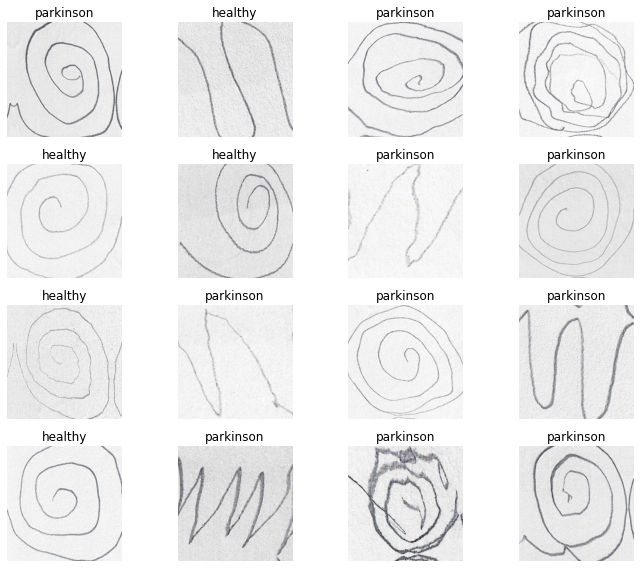

In [8]:
data.show_batch(rows=4, figsize=(10,8))

In [9]:
learn = cnn_learner(data, models.alexnet, metrics=accuracy, model_dir='/tmp/models')

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [10]:
# lets start training via one cycle 
learn.fit_one_cycle(1)
# should happen quickly since the dataset is relatively small

epoch,train_loss,valid_loss,accuracy,time
0,1.147422,0.670755,0.641975,00:05


In [11]:
interp = ClassificationInterpretation.from_learner(learn)

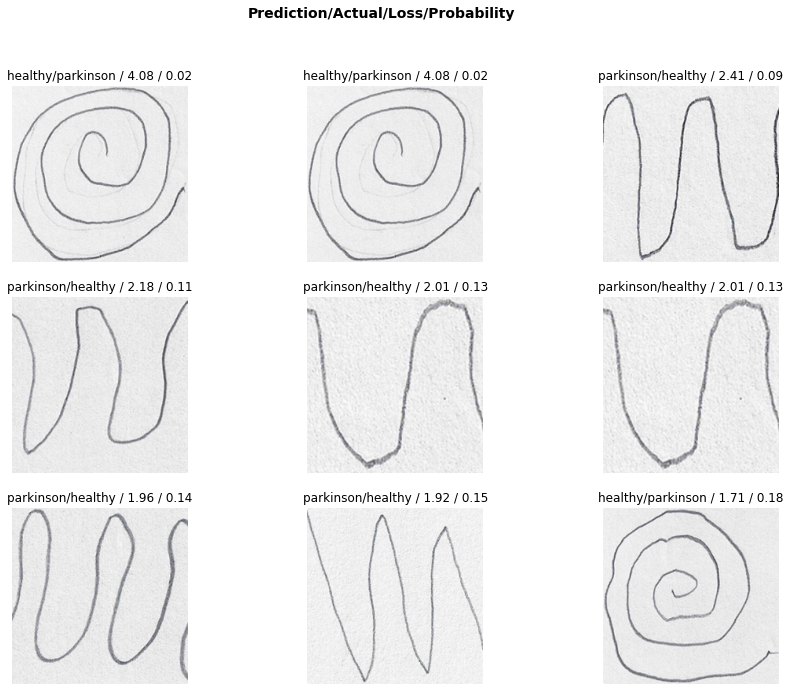

In [12]:
# show me what the model was most confident in yet, was incorrect.
losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

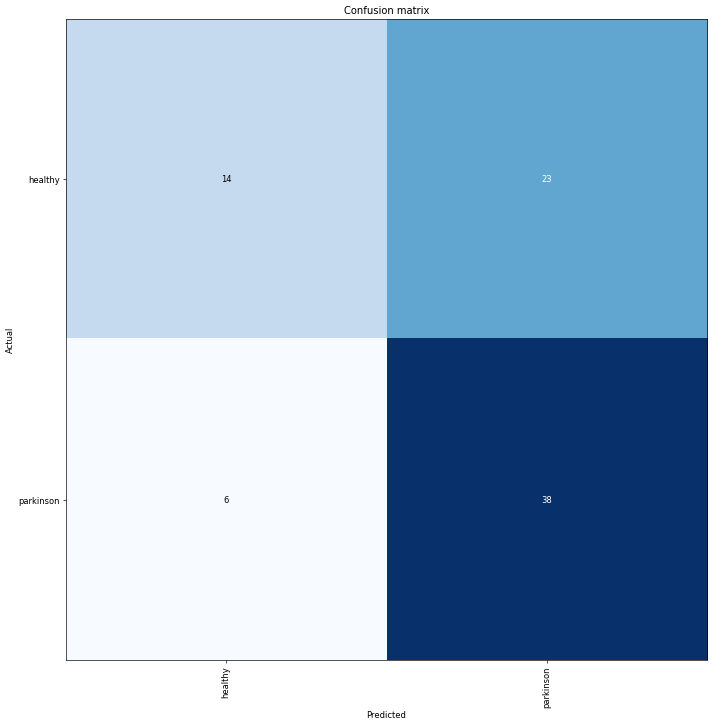

In [13]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [14]:
# lets unfreeze the remainder of the model to see if our model can do better 
learn.unfreeze()

In [16]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.789505,0.527676,0.814815,00:05
1,0.700819,0.559472,0.790123,00:05
2,0.689421,0.522165,0.765432,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05
Min loss divided by 10: 4.37E-04


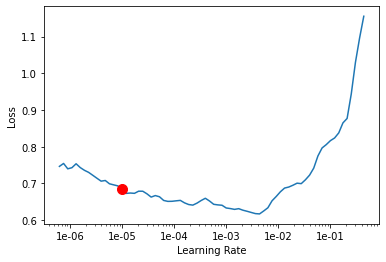

In [17]:
# lets try to find the learning rate to improve the model accuracy
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [18]:
# instead of the default max_lr
# lets pass our cycle the lowest learning rates suggested
learn.fit_one_cycle(10, max_lr=slice(1e-4,1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.654097,0.522914,0.765432,00:05
1,0.700743,0.546991,0.765432,00:05
2,0.702064,0.462109,0.802469,00:05
3,0.679337,0.424270,0.814815,00:05
4,0.658916,0.398474,0.814815,00:05
5,0.645660,0.402389,0.839506,00:05
6,0.633742,0.392734,0.839506,00:05
7,0.615530,0.370995,0.839506,00:05
8,0.604126,0.375592,0.839506,00:05
9,0.594775,0.392976,0.827160,00:05


In [19]:
learn.save('stage-2-86')

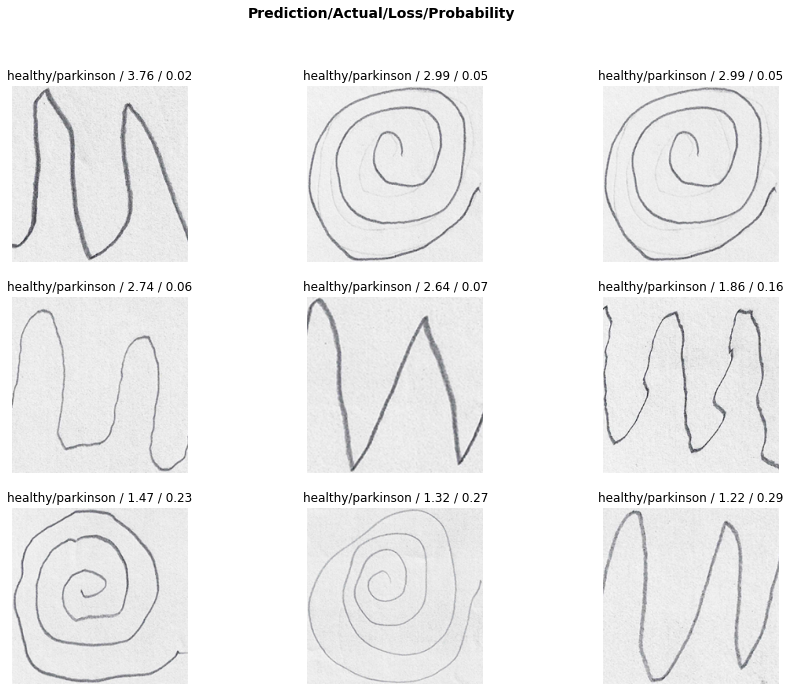

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

In [21]:
interp.most_confused()

[('parkinson', 'healthy', 12), ('healthy', 'parkinson', 2)]

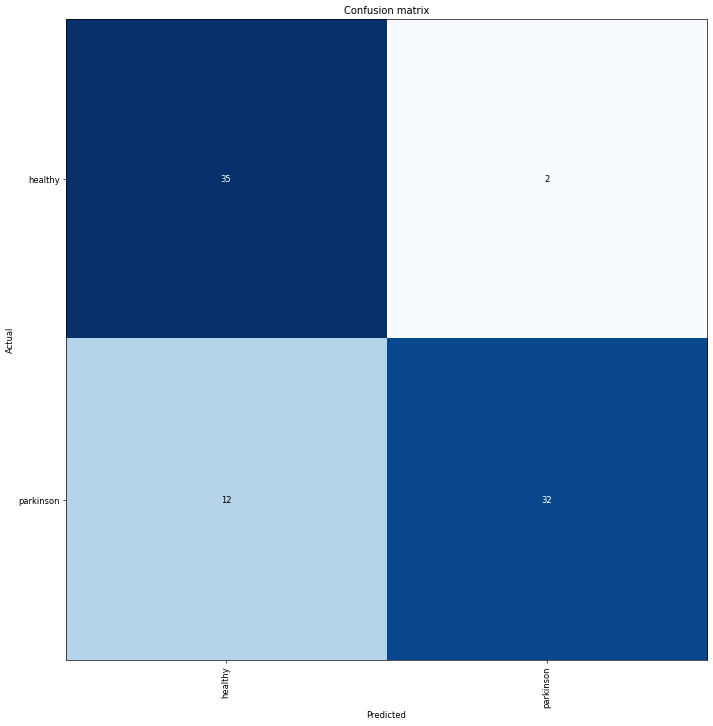

In [22]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [23]:
learn5 = cnn_learner(data, models.alexnet, metrics=accuracy, model_dir='/tmp/models')

In [24]:
# lets fit only our top layers to see how well she does 
learn5.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.127906,0.517223,0.802469,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 3.98E-03


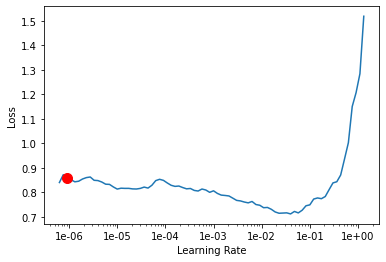

In [25]:
# Lets optimize
learn5.lr_find()
learn5.recorder.plot(suggestion=True)

In [26]:
learn5.fit_one_cycle(2, max_lr=slice(1e-2,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.825285,0.549768,0.777778,00:04
1,0.831450,0.589453,0.765432,00:04


In [27]:
# lets now unfreeze the rest to see if we can improve
learn5.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.51E-04


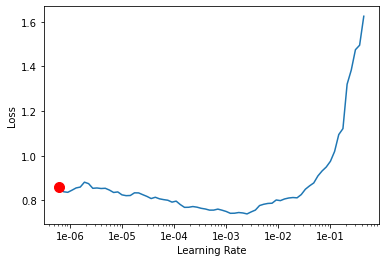

In [28]:
# Lets optimize
learn5.lr_find()
learn5.recorder.plot(suggestion=True)

In [29]:
# now lets fitting with a suggested lr instead of default
learn5.fit_one_cycle(20, max_lr=slice(1e-3,1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.823253,0.599442,0.790123,00:05
1,0.777825,0.967662,0.666667,00:05
2,0.826634,0.764203,0.666667,00:04
3,0.843817,0.578142,0.716049,00:05
4,0.830042,2.364795,0.506173,00:04
5,0.820152,3.487770,0.469136,00:05
6,0.816833,2.939806,0.481481,00:04
7,0.841389,0.903221,0.654321,00:05
8,0.829659,0.893094,0.641975,00:04
9,0.827821,0.853240,0.641975,00:04


In [30]:
interp50 = ClassificationInterpretation.from_learner(learn5)

In [31]:
interp50.most_confused()

[('parkinson', 'healthy', 21), ('healthy', 'parkinson', 3)]

In [32]:
learn5.save('stage-1-93')

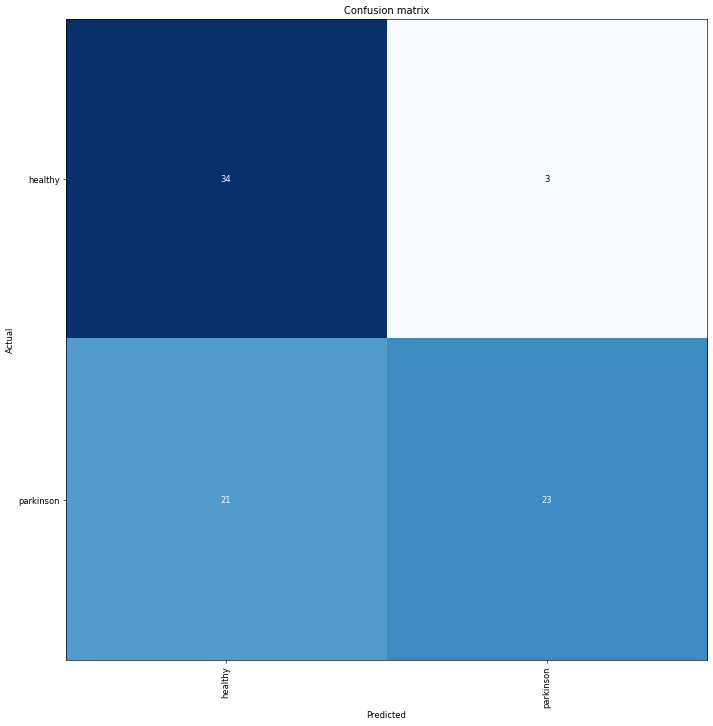

In [33]:
interp50.plot_confusion_matrix(figsize=(12,12), dpi=60)